In [2]:
import torch

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# Classifying Expert Weights (Ortho, Superposition, etc)
Implementation for n=2 and n=3 (each a separate function).

In [3]:
import torch
from helpers.helpers import classify_expert_weights_2d

# Sample expert weights with 2 features, 1 hidden dim
expert_weights_2d = torch.tensor([[[ 0.2857],
                                   [ 0.3748]],
                                  [[-0.9991],
                                   [ 0.4402]]])

# Classify and print results
classifications = classify_expert_weights_2d(expert_weights_2d)
print("\nExpert Weight Classifications (2D):")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")


Expert Weight Classifications (2D):

expert_0:
  Hidden dim 0: superposition_both_positive (similarity: 0.991)
    Weights: [0.2856999933719635, 0.3747999966144562]
    Pattern: [1.0, 1.0]

expert_1:
  Hidden dim 0: superposition_opposite (similarity: 0.932)
    Weights: [-0.9991000294685364, 0.44020000100135803]
    Pattern: [1.0, -1.0]


In [4]:
import torch
from helpers.helpers import classify_expert_weights_n3

# Sample expert weights with 3 features, 2 hidden dims (equiv. to model.W_experts)
expert_weights_3d = torch.tensor([
    # Expert 0
    [[ 0.7071,  0.0000],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ 0.7071,  0.0000],  # Feature 1: [hidden_dim_0, hidden_dim_1] 
        [ 0.0000,  1.0000]], # Feature 2: [hidden_dim_0, hidden_dim_1]
    
    # Expert 1
    [[ -0.5774,  0.5774],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ -0.5774,  -0.5774],  # Feature 1: [hidden_dim_0, hidden_dim_1]
        [ 0.5774, -0.5774]]  # Feature 2: [hidden_dim_0, hidden_dim_1]
])
    
# Classify and print results
classifications = classify_expert_weights_n3(expert_weights_3d)
print("\nExpert Weight Classifications:")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")


Expert Weight Classifications:

expert_0:
  Hidden dim 0: superposition_pair_feature_0_feature_1_positive (similarity: 1.000)
    Weights: [0.707099974155426, 0.707099974155426, 0.0]
    Pattern: [1.0, 1.0, 0.0]
  Hidden dim 1: orthogonal_feature_2 (similarity: 1.000)
    Weights: [0.0, 0.0, 1.0]
    Pattern: [0.0, 0.0, 1.0]

expert_1:
  Hidden dim 0: superposition_all_three_mixed (similarity: 1.000)
    Weights: [-0.5774000287055969, -0.5774000287055969, 0.5774000287055969]
    Pattern: [1.0, 1.0, -1.0]
  Hidden dim 1: superposition_all_three_mixed (similarity: 1.000)
    Weights: [0.5774000287055969, -0.5774000287055969, -0.5774000287055969]
    Pattern: [-1.0, 1.0, 1.0]


# Compute Router Probabilities

Given weight matrix, likelihood expert is activated via sampling. 

In [5]:
import torch
from helpers.helpers import compute_all_expert_probabilities, compute_router_probabilities
from model.model import MoEModel, Config, optimize

def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=3,
        n_hidden=2,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1 for _ in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=3000, print_freq=250, lr=1e-3)

# Example usage:
print("Gate matrix:")
print(model.gate)

print(f"\nFeature probability: {model.feature_probability.item()}")

# Compute probabilities
prob_with_data, prob_without_data = compute_router_probabilities(
    model.gate, 
    feature_probability=model.feature_probability,
    n_samples=10000
)

print(f"\nRouter probabilities for first expert:")
print(f"With data sparsity: {prob_with_data:.3f}")
print(f"Without data sparsity (uniform): {prob_without_data:.3f}")

Step 0: loss=0.065778, lr=0.001000
Step 250: loss=0.020150, lr=0.001000
Step 500: loss=0.017521, lr=0.001000
Step 750: loss=0.014021, lr=0.001000
Step 1000: loss=0.013208, lr=0.001000
Step 1250: loss=0.014059, lr=0.001000
Step 1500: loss=0.010778, lr=0.001000
Step 1750: loss=0.013882, lr=0.001000
Step 2000: loss=0.010020, lr=0.001000
Step 2250: loss=0.010292, lr=0.001000
Step 2500: loss=0.011476, lr=0.001000
Step 2750: loss=0.008902, lr=0.001000
Step 2999: loss=0.011971, lr=0.001000
Gate matrix:
Parameter containing:
tensor([[-1.9460, -1.9460, -1.9439],
        [ 1.8822,  1.8902,  1.8913],
        [ 1.8853,  1.8923,  1.8911],
        [ 1.8952,  1.8852,  1.8802]], requires_grad=True)

Feature probability: 0.10000000149011612

Router probabilities for first expert:
With data sparsity: 0.200
Without data sparsity (uniform): 0.005


In [6]:
# For multiple experts, you can also compute for each expert:

# Compute for all experts
probs_with_data, probs_without_data = compute_all_expert_probabilities(
    model.gate, 
    feature_probability=model.feature_probability
)

print(f"\nRouter probabilities for all experts:")
for i in range(len(probs_with_data)):
    print(f"Expert {i}: with_data={probs_with_data[i]:.3f}, without_data={probs_without_data[i]:.3f}")


Router probabilities for all experts:
Expert 0: with_data=0.201, without_data=0.005
Expert 1: with_data=0.266, without_data=0.331
Expert 2: with_data=0.267, without_data=0.332
Expert 3: with_data=0.266, without_data=0.331


# Tracker Expert Allocation over Time

Currently only supports for k=1.

Step 0: loss=0.932442, lr=0.001000

Step 50 - Router evolution:
  Expert 1: 30.70%
  Expert 2: 20.40%
  Expert 0: 29.00%
  Expert 3: 19.90%

Step 100 - Router evolution:
  Expert 0: 22.80%
  Expert 2: 22.30%
  Expert 1: 23.10%
  Expert 3: 31.80%

Step 150 - Router evolution:
  Expert 1: 25.10%
  Expert 0: 29.30%
  Expert 3: 24.10%
  Expert 2: 21.50%

Step 200 - Router evolution:
  Expert 1: 24.30%
  Expert 0: 19.10%
  Expert 2: 28.20%
  Expert 3: 28.40%

Step 250 - Router evolution:
  Expert 0: 27.50%
  Expert 1: 23.40%
  Expert 2: 28.50%
  Expert 3: 20.60%
Step 250: loss=0.541856, lr=0.001000

Step 300 - Router evolution:
  Expert 2: 23.20%
  Expert 1: 24.00%
  Expert 3: 30.00%
  Expert 0: 22.80%

Step 350 - Router evolution:
  Expert 3: 25.20%
  Expert 0: 24.70%
  Expert 1: 25.70%
  Expert 2: 24.40%

Step 400 - Router evolution:
  Expert 0: 27.60%
  Expert 3: 21.30%
  Expert 2: 22.30%
  Expert 1: 28.80%

Step 450 - Router evolution:
  Expert 2: 14.70%
  Expert 0: 34.70%
  Expert 1: 1

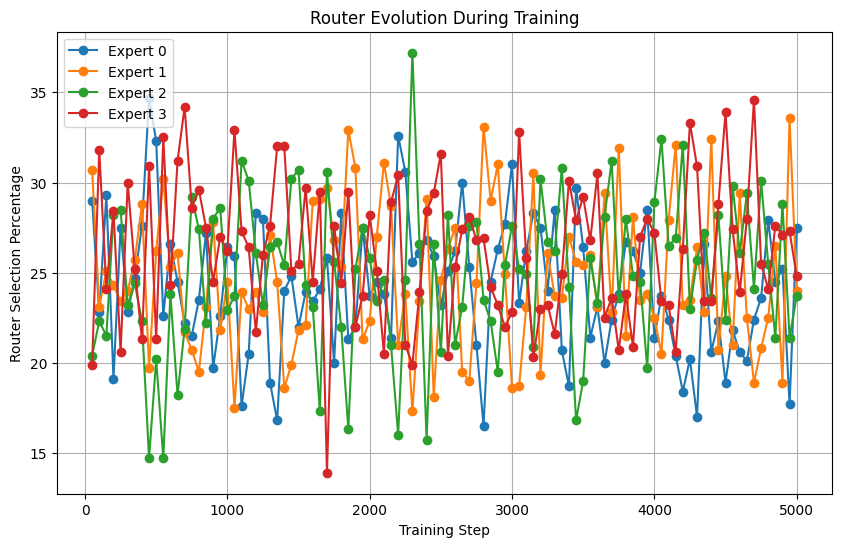

Parameter containing:
tensor([[ 3.4326e-03, -1.1000e-04,  3.1004e-03,  1.0272e-03,  2.9473e-03,
          1.0370e-03,  1.1481e-03,  1.2044e-03,  1.1435e-03,  2.6912e-03,
          2.8252e-03,  2.5662e-03, -6.9143e-05, -2.8194e-04, -9.7144e-04,
          2.8208e-03,  2.6161e-03, -2.3196e-03, -4.5970e-03, -9.3734e-04,
          1.5609e-03,  2.8429e-03, -1.0448e-03,  1.4816e-03,  6.5756e-04,
          4.1702e-03,  1.7377e-03,  1.6730e-03,  3.3017e-03,  1.8867e-03,
          5.0359e-04,  2.7405e-03],
        [ 1.6769e-03,  5.1267e-03,  1.8512e-03,  8.5584e-04,  4.4517e-03,
         -7.9305e-04, -3.7814e-04, -1.4699e-03,  3.0395e-04,  1.1086e-03,
          1.2422e-04,  1.4684e-03, -1.8601e-04,  2.4841e-03,  3.6229e-03,
          1.3003e-03, -4.2885e-03,  3.2678e-04,  2.6515e-03,  2.4123e-03,
          1.2469e-03,  1.2313e-03,  2.4853e-03,  2.1792e-03,  3.0321e-03,
         -1.4914e-03,  2.9671e-03,  2.1322e-03, -3.0399e-03,  3.4657e-04,
          2.4378e-03,  1.9202e-03],
        [-1.8190e-

In [7]:
import torch
from helpers.helpers import RouterEvolutionHook
from model.model import MoEModel, Config, optimize


def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=32,
        n_hidden=8,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1 for _ in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

# Train with hook
# model = create_model()
# router_hook = RouterSelectionHook()
# optimize(model, n_batch=512, steps=5000, print_freq=100, lr=1e-3, hooks=[router_hook])
# router_hook.print_statistics()

# Or train with evolution tracking
model = create_model()
evolution_hook = RouterEvolutionHook(log_interval=50)
optimize(model, n_batch=512, steps=5000, print_freq=250, lr=1e-3, hooks=[evolution_hook])
evolution_hook.plot_evolution()

print(model.gate)
print(model.W_experts)